## DeepXDE求解常微分方程
这个notebook展示了使用DeepXDE求解常微分方程。

1. [一个简单的 ODE 系统](#ODE1)
2. [Lotka-Volterra 方程](#ODE2)
3. [劳伦兹混沌系统 Lorenz Chaos Problem](#ODE3)

In [2]:
# 绘图的辅助函数

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_loss_history(loss_history):
    """Plot the training and testing loss history.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        loss_history: ``LossHistory`` instance. The first variable returned from
            ``Model.train()``.
    """
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=(10, 8))
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    


def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure(figsize=(10, 6))
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            plt.plot(X, best_y[idx, i], "--r", label="Prediction")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure(figsize=(20, 12))
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))

    plt.show()

<a id="ODE1"></a>
## 一个简单的 ODE 系统

### 问题设置

我们将求解一个简单的 ODE 系统：

$$\large \frac{dy_1}{dt} = y_2 ,\,\,\,\, \frac{dy_2}{dt} = -y_1,\,\,\,\, where \,\,\,\,t∈[0,10],$$



与初始条件 $\large y_1(0)=0,y_2(0)=1.$

参考解决方案是 $$ \large  y_1 = \sin(x) ,\,\,\,\, y_2 = \cos(x).$$

源码：

https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/ode_system.py

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/ode.system.html

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



data.PDE

指定几何区域、ODE 和初始条件

In [95]:
def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [10/scale*dy1_x - y2, 10/scale*dy2_x + y1]

def boundary(_, on_initial):
    return on_initial
# def boundary(x, on_initial):
#     return np.isclose(x[0], 0)

def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))

In [96]:
# geom = dde.geometry.TimeDomain(0, 10)
# ic1 = dde.icbc.IC(geom, np.sin, boundary, component=0)
# ic2 = dde.icbc.IC(geom, np.cos, boundary, component=1)
# # data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)
# data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, num_test=100)

In [97]:
scale = 100

geom = dde.geometry.TimeDomain(0, 1.)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)

num_domain = 80*scale
num_boundary = 2
num_test = 80*scale

data = dde.data.PDE(geom, ode_system, [ic1, ic2],
                    num_domain=num_domain,
                    num_boundary=num_boundary,
                    num_test=num_test,
                    train_distribution="uniform")

In [98]:
# 在神经网络中，输入值必须做归一化，输入值不能过大
# 一个错误的例子，把超过10的数输入了神经网络。

# geom = dde.geometry.TimeDomain(0, 100)
# ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
# ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
# # data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)
# data = dde.data.PDE(geom, ode_system, [ic1, ic2], 10000, 2, num_test=20000)

net

In [99]:
layer_size = [1] + [100] * 10 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

model

In [100]:
# model.compile("adam", lr=0.001, metrics=["l2 relative error"])
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.150618 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.021239 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.21e-03, 9.73e-03, 0.00e+00, 1.00e+00]    [3.21e-03, 9.73e-03, 0.00e+00, 1.00e+00]    []  
1000      [5.47e-04, 7.47e-04, 1.21e-07, 1.13e-05]    [5.46e-04, 7.44e-04, 1.21e-07, 1.13e-05]    []  
2000      [3.06e-06, 6.24e-06, 5.78e-08, 4.80e-08]    [3.05e-06, 6.16e-06, 5.78e-08, 4.80e-08]    []  
3000      [4.26e-03, 3.50e-03, 1.20e-06, 1.02e-04]    [4.25e-03, 3.50e-03, 1.20e-06, 1.02e-04]    []  
4000      [6.75e-06, 4.69e-06, 9.78e-07, 7.14e-08]    [6.68e-06, 4.66e-06, 9.78e-07, 7.14e-08]    []  
5000      [1.75e-02, 1.47e-02, 3.66e-04, 5.95e-04]    [1.75e-02, 1.47e-02, 3.66e-04, 5.95e-04]    []  
6000      [2.95e-05, 3.48e-05, 5.11e-05, 7.79e-07]    [2.92e-05, 3.45e-05, 5.11e-05, 7.79e-07]    []  
7000      [4.46e-05, 7.25e-05, 2.87e-04, 3.98e-08]    [4.45e-05, 7.25e-05, 2.87e-04, 3.98e-08]   

plot

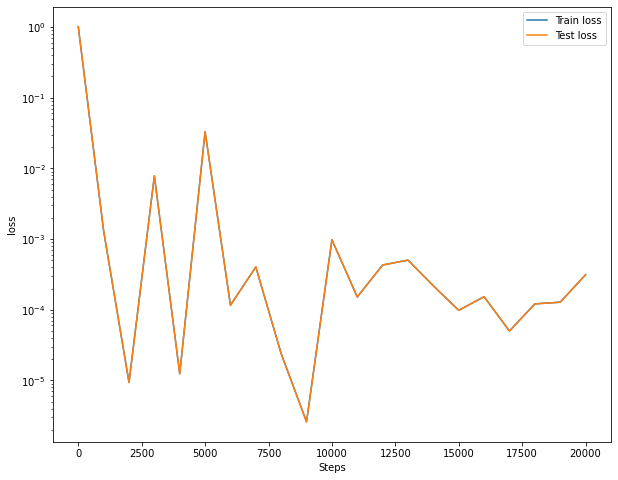

In [101]:
plot_loss_history(losshistory)

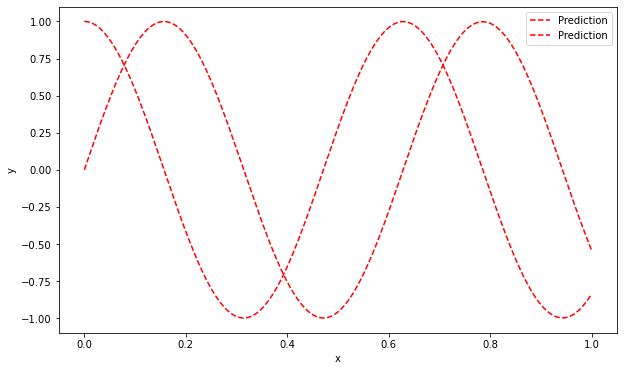

In [104]:
plot_best_state(train_state)

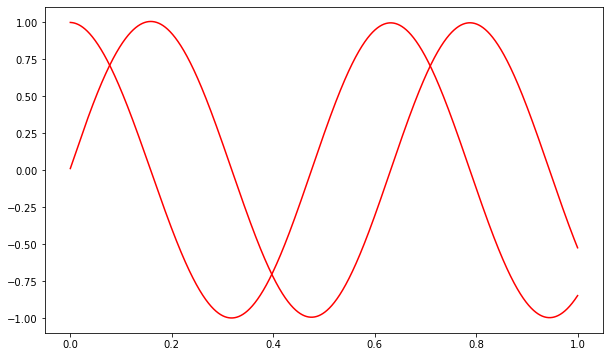

In [105]:
t_list = data.test()[0]
pre_data = model.predict(t_list)
plt.figure(figsize=(10, 6))
plt.plot(t_list, pre_data[:,0], "-r", label="True")
plt.plot(t_list, pre_data[:,1], "-r", label="True")

### 真实值

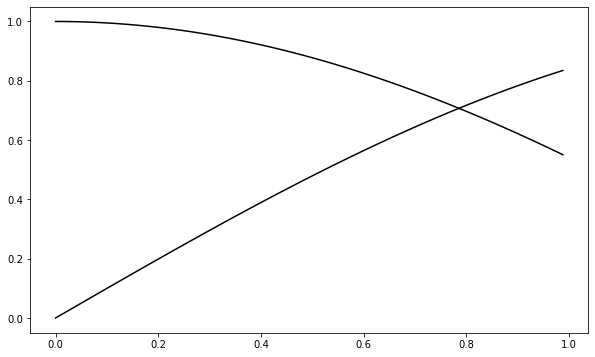

In [94]:
t_list = data.test()[0]*scale  # scale=1
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.plot(t_list, true_data[:,0], "-k", label="True")
plt.plot(t_list, true_data[:,1], "-k", label="True")

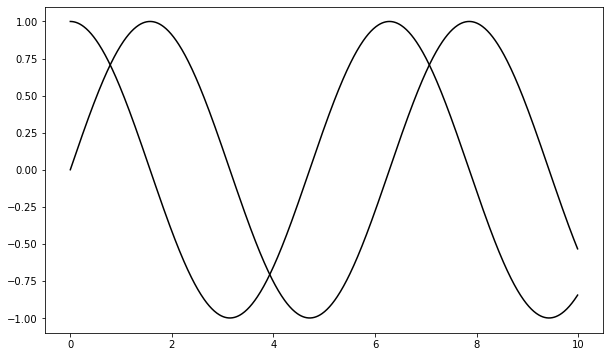

In [91]:
t_list = data.test()[0]*scale  # scale=10
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.plot(t_list, true_data[:,0], "-k", label="True")
plt.plot(t_list, true_data[:,1], "-k", label="True")

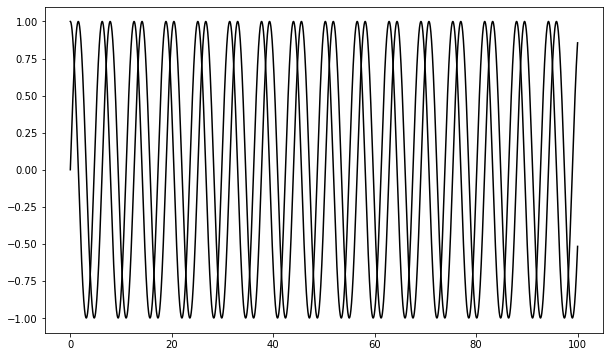

In [88]:
t_list = data.test()[0]*scale  # scale=100
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.plot(t_list, true_data[:,0], "-k", label="True")
plt.plot(t_list, true_data[:,1], "-k", label="True")

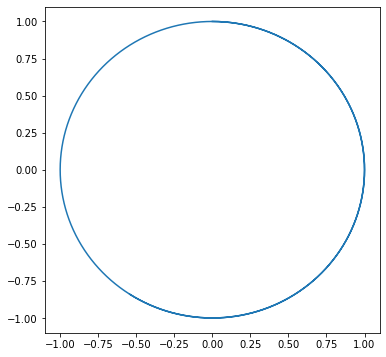

In [50]:
plt.figure(figsize=(6, 6))
plt.plot(true_data[:,0], true_data[:,1])

<a id="ODE2"></a>

# Lotka-Volterra 方程

## 问题设置

我们将求解一个 Lotka-Volterra 方程：
$$
\Large
\begin{cases}
\frac{dr}{dt} &= \frac{R}{U} (2 U r - 0.04 U^2 r p), \\
\frac{dp}{dt} &= \frac{R}{U} (0.02 U^2 r p - 1.06 U p), \\
\end{cases}\\
\large initial\,\,condition: r(0) = \frac{100}{U}, p(0) = \frac{15}{U},\\
\large parameters: U = 200,R=20.\\
$$
第一个参数 $U$ 近似于范围的上限，第二个参数 $R$ 是域的右边界。这两个参数将用于缩放。

参考解决方案是使用`scipy` 的方法`integrate.solve_ivp()`生成的。

### 执行

本描述逐步介绍了上述 Lotka-Volterra 方程的求解器的实现。

首先，导入 DeepXDE、numpy、matplotlib 和 scipy 包：

In [35]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf

我们首先定义范围的近似上限和域的右边界。稍后，当绘制人口与时间的关系图时，我们通过这些因素进行缩放以获得 0 和 1 之间的图表。

In [36]:
ub = 200
rb = 20

我们现在定义一个时域。我们通过使用内置类来做到这一点`TimeDomain`：

In [37]:
geom = dde.geometry.TimeDomain(0.0, 1.0)

接下来，我们表达 ODE 系统：

In [38]:
def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]

第一个论点`ode_system`是tt-坐标，由 表示`x`。第二个参数是一个二维向量，表示为`y`，它包含 $r(t)$ 和 $p(t)$.

现在，我们将 ODE 问题定义为

In [39]:
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test = 3000)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3002=3002. 
  warnings.warn("The balance properties of Sobol' points require "


请注意，在求解这个方程时，我们希望对初始条件有硬约束，因此我们稍后在创建网络时定义它，而不是作为 PDE 的一部分。

我们在域内有 3000 个训练残差点，在边界上有 2 个点。我们使用 3000 个点来测试 ODE 残差。我们现在创建网络：

In [40]:
layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

这是一个深度为 7 的神经网络，有 6 个隐藏层，宽度为 50。我们使用 tanh 作为激活函数。

由于我们希望在 Lotka-Volterra 方程中具有周期性行为，因此我们添加了一个特征层 $\sin(kt)$. 这迫使预测是周期性的，因此更准确。


In [41]:
def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )

如前所述，我们想要初始条件 $r(0)=100U$ 和 $p(0)=15U$ 是硬约束，所以我们转换输出：

In [42]:
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]

    return tf.concat(
        [y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1
    )

我们添加这些层：

In [43]:
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

现在我们已经定义了神经网络，我们构建一个`Model`，选择优化器和学习率，并训练它进行 50000 次迭代：

In [44]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=50000)

Compiling model...
Building feed-forward neural network...
'build' took 0.095743 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.062383 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.98e+02, 1.15e+00]    [4.99e+02, 1.15e+00]    []  
1000      [3.34e+00, 6.89e-01]    [3.33e+00, 6.88e-01]    []  
2000      [1.80e+00, 5.61e-01]    [1.79e+00, 5.57e-01]    []  
3000      [8.78e-01, 4.21e-01]    [8.67e-01, 4.18e-01]    []  
4000      [5.08e-01, 1.97e-01]    [5.02e-01, 1.95e-01]    []  
5000      [3.08e-01, 1.24e-01]    [3.05e-01, 1.22e-01]    []  
6000      [2.01e-01, 6.87e-02]    [1.99e-01, 6.75e-02]    []  
7000      [1.18e-01, 5.08e-02]    [1.17e-01, 4.99e-02]    []  
8000      [9.96e-02, 4.17e-02]    [9.89e-02, 4.11e-02]    []  
9000      [5.60e-02, 2.82e-02]    [5.56e-02, 2.77e-02]    []  
10000     [4.61e-02, 2.25e-02]    [4.59e-02, 2.21e-02]    []  
11000     [3.27e-02, 1.40e-02]    [3.26e-02, 1.37e-02]    []  
12000     [3.26e-02, 1.00e-02]    [3.25e-02, 9.80e-03]    []  
13000     [4.32e-02, 8.48e-03]    [4.31

在与 Adam 训练之后，我们继续使用 L-BFGS 以获得更小的损失：

In [45]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.646382 s

Training model...

Step      Train loss              Test loss               Test metric
50000     [1.51e-02, 1.18e-03]    [1.51e-02, 1.19e-03]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.016012
  Number of iterations: 30
  Number of functions evaluations: 67
50067     [1.47e-02, 1.33e-03]    [1.47e-02, 1.35e-03]    []  

Best model at step 50067:
  train loss: 1.60e-02
  test loss: 1.60e-02
  test metric: []

'train' took 2.121436 s



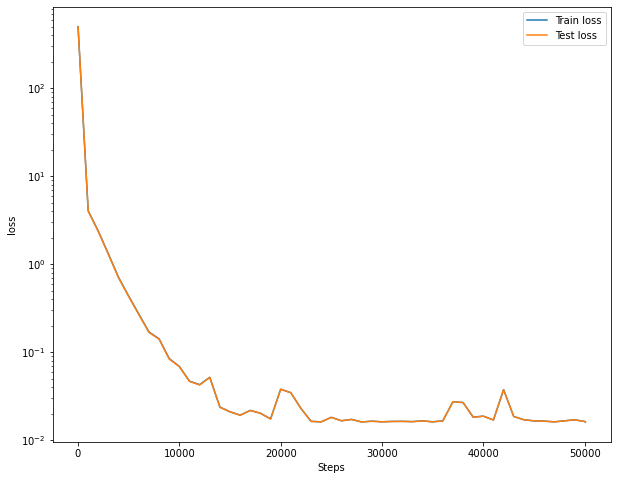

In [47]:
plot_loss_history(losshistory)

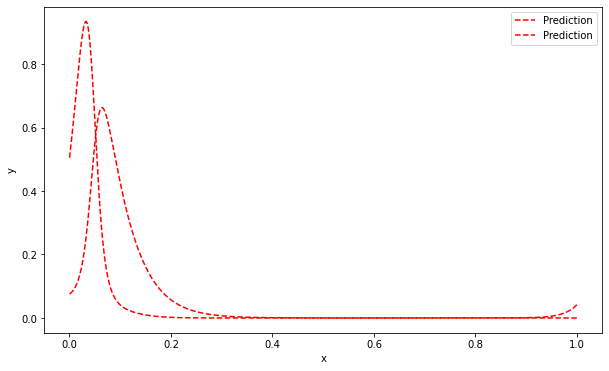

In [48]:
plot_best_state(train_state)

获取真实解

In [55]:
def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true

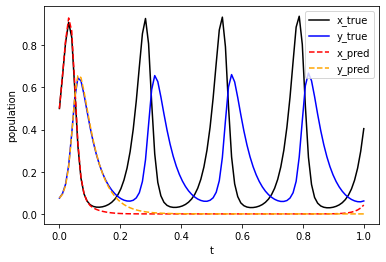

In [56]:
plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

<a id="ODE3"></a>
## 劳伦兹混沌系统 Lorenz Chaos Problem
### 问题设置

我们将求解一个简单的 ODE 系统：

$$
\large
\begin{cases}
\frac{dx}{dt} = \sigma(y-x), \\
\frac{dy}{dt} = \rho x - y - x z, \\
\frac{dz}{dt} = x y - \beta z, \\
\end{cases}\\
\large \sigma = 10,\beta = 8/3,\rho = 28, t \in [0,500]
$$

与初始条件 $\large x(0)=0,y(0)=0,z(0)=0.$

与初始条件 $\large x(0)=10^{-5},y(0)=0,z(0)=0.$

In [106]:
import deepxde as dde
import numpy as np

In [107]:
sigma = 10
beta = 8./3
rho = 28

def ode_system(t, y_list):
    """ODE system.
    t = (t),y_list = (x,y,z)
    """
    x, y, z = y_list[:, 0:1], y_list[:, 1:2], y_list[:, 2:]
    dx_t = dde.grad.jacobian(y_list, t, i=0)
    dy_t = dde.grad.jacobian(y_list, t, i=1)
    dz_t = dde.grad.jacobian(y_list, t, i=2)
    return [scale*dx_t-sigma*(y-x), scale*dy_t-rho*x+y+x*z, scale*dz_t-x*y+beta*z]

def boundary(_, on_initial):
    return on_initial

In [108]:
scale =  500

geom = dde.geometry.TimeDomain(0., 1.)
ic1 = dde.icbc.IC(geom, lambda x: 1e-5, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)


num_domain = 60*scale
num_boundary = 3
num_test = 60*scale

# data = dde.data.PDE(geom, ode_system, [ic1, ic2, ic3],
#                     num_domain=num_domain,
#                     num_boundary=num_boundary,
#                     num_test=num_test,
#                     train_distribution="pseudo")

data = dde.data.PDE(geom, ode_system, [ic1, ic2, ic3],
                    num_domain=num_domain,
                    num_boundary=num_boundary,
                    num_test=num_test,
                    train_distribution="uniform")

In [109]:
data.train_next_batch()[0].shape

(30006, 1)

In [110]:
layer_size = [1] + [100] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [111]:
def input_transform(t):
    return t*scale
net.apply_feature_transform(input_transform)

In [112]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.084607 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.993325 s



In [113]:
losshistory, train_state = model.train(epochs=20000)

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.70e+06, 3.09e+06, 3.58e+05, 1.00e-10, 0.00e+00, 0.00e+00]    [4.70e+06, 3.05e+06, 3.58e+05, 1.00e-10, 0.00e+00, 0.00e+00]    []  
1000      [5.74e+00, 1.05e+01, 1.95e+00, 2.80e-04, 1.83e-04, 4.49e-03]    [5.66e+00, 1.03e+01, 1.95e+00, 2.80e-04, 1.83e-04, 4.49e-03]    []  
2000      [5.38e-01, 1.80e+00, 1.11e+00, 1.74e-04, 8.01e-04, 1.11e-03]    [5.38e-01, 1.72e+00, 1.11e+00, 1.74e-04, 8.01e-04, 1.11e-03]    []  
3000      [6.35e-01, 7.65e-01, 7.86e-01, 2.32e-06, 1.36e-04, 1.15e-04]    [6.34e-01, 7.29e-01, 7.84e-01, 2.32e-06, 1.36e-04, 1.15e-04]    []  
4000      [6.70e-01, 6.82e-01, 6.37e-01, 2.13e-05, 4.02e-05, 3.02e-04]    [6.69e-01, 6.54e-01, 6.34e-01, 2.13e-05, 4.02e-05, 3.02e-04]    []  
5000      [5.59e-01, 4.97e-01, 7.91e-01, 9.12e-06, 2.37e-04, 3.64e-03]    [5.54e-01, 4.75e

In [114]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 1.079250 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
20000     [8.88e-03, 5.90e-03, 4.16e-03, 9.85e-03, 9.36e-04, 6.17e-08]    [8.88e-03, 5.87e-03, 4.14e-03, 9.85e-03, 9.36e-04, 6.17e-08]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.001183
  Number of iterations: 207
  Number of functions evaluations: 245
20245     [5.49e-04, 2.52e-04, 3.38e-04, 7.70e-06, 3.59e-05, 9.65e-07]    [5.39e-04, 2.47e-04, 3.36e-04, 7.70e-06, 3.59e-05, 9.65e-07]    []  

Best model at step 20245:
  train loss: 1.18e-03
  test loss: 1.17e-03
  test metric: []

'train' took 61.025605 s



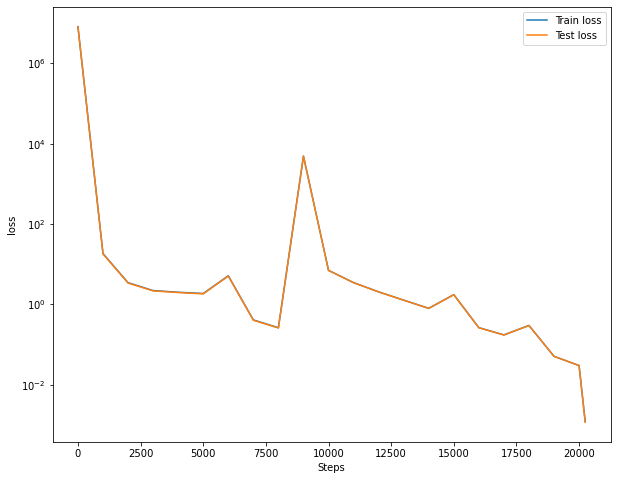

In [115]:
plot_loss_history(losshistory)

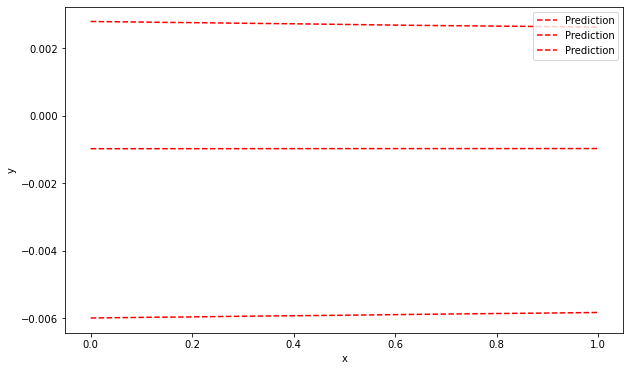

In [116]:
plot_best_state(train_state)

In [117]:
pre_data = _pack_data(train_state)[2]
# pre_data = model.predict(data.test()[0])

pre_data

array([[ 0.00278425, -0.0059925 , -0.00098211],
       [ 0.00278425, -0.0059925 , -0.00098211],
       [ 0.00278425, -0.0059925 , -0.00098211],
       ...,
       [ 0.00261229, -0.00582939, -0.00097752],
       [ 0.00261226, -0.00582936, -0.0009771 ],
       [ 0.00261226, -0.0058293 , -0.00097704]], dtype=float32)

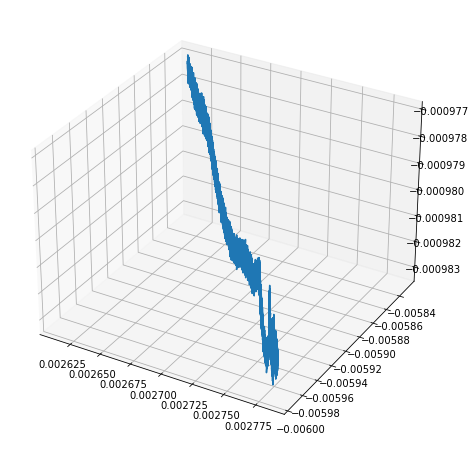

In [118]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
# ax.scatter3D(pre_data[:,0], pre_data[:,1],pre_data[:,2])
ax.plot3D(pre_data[:,0], pre_data[:,1],pre_data[:,2])

## 学到更多

求解一个 Lotka-Volterra 方程：https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/lotka.volterra.html

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward.html#odes